Text classification example.

References:
- https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

The dataset was preprocessed in **finance complaints dataset analysis** notebook.

In [1]:
import pandas as pd
df = pd.read_csv('complaints-balanced.csv')
df.head()

,Unnamed: 0,Product,Consumer_complaint_narrative,category_id
0,0,"Credit reporting, credit repair services, or o...",My XXXX XXXX Account Was Paid Off But They Hav...,0
1,1,"Credit reporting, credit repair services, or o...",I had a citibank checking account which I clos...,0
2,2,"Credit reporting, credit repair services, or o...",I would like to request the suppression of the...,0
3,3,"Credit reporting, credit repair services, or o...",Account from XXXX with a balance is reporting ...,0
4,4,"Credit reporting, credit repair services, or o...",The credit bureaus are reporting inaccurate/ou...,0


In [2]:
print(df.isnull().sum())

Unnamed: 0                      0
Product                         0
Consumer_complaint_narrative    0
category_id                     0
dtype: int64


Text preprocessing and generation of text vector representations based on TF-IDF.
- `sublinear_tf` is set to `True` to use a logarithmic form for frequency.
- `min_df` is the minimum numbers of documents a word must be present in to be kept.
- `norm is set` to `l2`, to ensure all our feature vectors have a euclidian norm of 1.
- `ngram_range` is set to `(1, 2)` to indicate that we want to consider both unigrams and bigrams.

In [3]:
%%time
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

text = df.Consumer_complaint_narrative

# removing XXX words
text = text.apply(lambda x: re.sub(r'X*', '', x))

# converting to lower case
text = text.apply(lambda x: x.lower())

# replacing symbols with spaces
text = text.apply(lambda x: re.sub(r'[/(){}\[\]\|@,;]', ' ', x))

# removing bad symbols
text = text.apply(lambda x: re.sub(r'[^0-9a-z #+_]', '', x))

# removing numbers
text = text.apply(lambda x: re.sub(r'\d+', '', x))

# removing stop words
STOPWORDS = set(stopwords.words('english'))
text = text.apply(lambda x: ' '.join(word for word in x.split() if word not in STOPWORDS))

CPU times: user 2.39 s, sys: 72.2 ms, total: 2.46 s
Wall time: 2.46 s


In [4]:
def print_example(index):
    print("-"*50)
    print("* BEFORE: {}".format(df.Consumer_complaint_narrative[index]))
    print("\n* AFTER: {}\n".format(text[index]))
    
print_example(0)
print_example(10)
print_example(50)

--------------------------------------------------
* BEFORE: My XXXX XXXX Account Was Paid Off But They Have Left The Wrong Information On My Credit Report For 11 Years The Account Should Be Removed It Is Too OldAnd A Medical Account That I Believed To Be Payed Off Has Also Been Left On My Report

* AFTER: account paid left wrong information credit report years account removed oldand medical account believed payed also left report

--------------------------------------------------
* BEFORE: Please be advised this is my THIRD WRITTEN REQUEST and FINAL WARNING that I fully intend to pursue litigation in accordance with the FCRA to enforce my rights and seek relief and recover all monetary damages that I may be entitled to under Section 616 and Section 617 regarding your continued willful and negligent noncompliance.

Despite two written requests, the unverified items listed below still remain on my credit report in violation of Federal Law. You are required under the FCRA to have a copy

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

Y = df['category_id']

sss = StratifiedShuffleSplit(n_splits=1, 
                             test_size=0.3, 
                             random_state=0)
for train_index, test_index in sss.split(text, Y):
    train_sentences = text.loc[train_index]
    Y_train = Y[train_index]
    test_sentences = text.loc[test_index]
    Y_test = Y[test_index]

In [6]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(encoding='latin-1', 
                        min_df=5, 
                        norm='l2', 
                        ngram_range=(1, 2), 
                        sublinear_tf=True)
X_train = tfidf.fit_transform(train_sentences).toarray()
X_test = tfidf.transform(test_sentences).toarray()

print("X_train.shape: ", X_train.shape)
print("Y_train.shape: ", Y_train.shape)
print("X_test.shape: ", X_test.shape)
print("Y_test.shape: ", Y_test.shape)

X_train.shape:  (2516, 8855)
Y_train.shape:  (2516,)
X_test.shape:  (1079, 8855)
Y_test.shape:  (1079,)
CPU times: user 1.69 s, sys: 236 ms, total: 1.92 s
Wall time: 1.65 s


### Model selection

In [7]:
%%time
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

models = [
    RandomForestClassifier(n_estimators=200, 
                           max_depth=3, 
                           random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver='lbfgs', 
                       multi_class='auto', 
                       random_state=0),
]
CV = 5
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, 
                               X_train, 
                               Y_train, 
                               scoring='accuracy', 
                               cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, 
                    fold_idx, 
                    accuracy))
cv_df = pd.DataFrame(entries, 
                     columns=['model_name', 'fold_idx', 'accuracy'])

CPU times: user 34.2 s, sys: 437 ms, total: 34.7 s
Wall time: 21.3 s


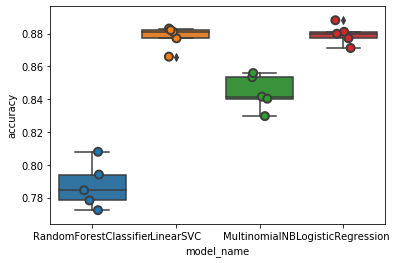

model_name
LinearSVC                 0.877964
LogisticRegression        0.879585
MultinomialNB             0.844214
RandomForestClassifier    0.787369
Name: accuracy, dtype: float64

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.boxplot(x='model_name', 
            y='accuracy', 
            data=cv_df)
sns.stripplot(x='model_name', 
              y='accuracy', 
              data=cv_df, 
              size=8, 
              jitter=True, 
              edgecolor="gray", 
              linewidth=2)
plt.show()
cv_df.groupby('model_name').accuracy.mean()

Best model evaluation

In [9]:
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

my_tags = df.category_id.unique()
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(my_tags))
    target_names = my_tags
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=my_tags)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    
    return cm

accuracy 0.8674698795180723
confusion matrix
 [[181  19   6   8   2]
 [ 26 167  12   6   5]
 [  7   4 190   0  14]
 [  6   0   4 204   2]
 [  3   3  15   1 194]]
(row=expected, col=predicted)
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       216
           1       0.87      0.77      0.82       216
           2       0.84      0.88      0.86       215
           3       0.93      0.94      0.94       216
           4       0.89      0.90      0.90       216

    accuracy                           0.87      1079
   macro avg       0.87      0.87      0.87      1079
weighted avg       0.87      0.87      0.87      1079

CPU times: user 6.95 s, sys: 20 ms, total: 6.97 s
Wall time: 3.51 s


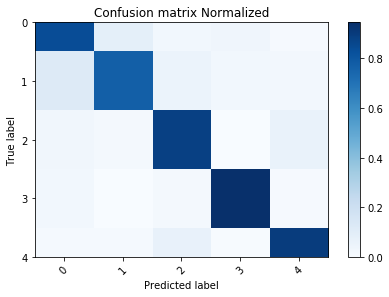

In [10]:
%%time
from sklearn import metrics

model = models[3]
model.fit(X_train, 
          Y_train)
y_pred = model.predict(X_test)
cm = evaluate_prediction(y_pred, 
                         Y_test)
print(metrics.classification_report(Y_test, y_pred))